In [ ]:
%matplotlib inline

# Libraries

In [291]:
import pymc3 as pm
import theano.tensor as tt
import numpy as np
import theano
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import seaborn as sns
import random
import itertools
import sklearn.gaussian_process

In [95]:
plt.style.use('indigo-white')

/home/ubuntu/anaconda3/envs/pymc_sql_env/lib/python3.6/site-packages/matplotlib/style/core.py:51: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring
  "to style.  Ignoring".format(key))


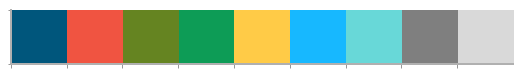

In [307]:
palette = sns.color_palette()
sns.palplot(palette)

# Random Variable

A random variable $Y$ is defined as a function that maps from a set of possible outcomes of an unpredictable process $\Omega $ to a measurable space $E$: 

$$Y: \Omega \rightarrow E (E \subseteq \mathbb{R})$$

## Coin flip

One flip

In [10]:
p_head = 0.5 #Probability of Heads
n = 100 #Number of experiments

In [48]:
Ω1 = [0,1] #Outcome space

experiment = lambda x: random.choice(Ω1)
Y1 = lambda ω: ω #Random variable

In [31]:
ω = list(map(experiment, np.arange(n)
            )
        ) #Generate samples

In [32]:
y1 = list(map(Y1, ω))

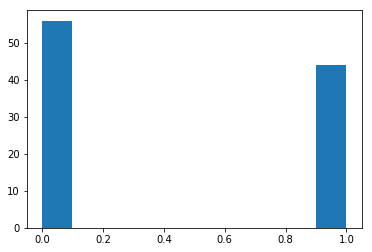

In [33]:
_ = plt.hist(y1)

Multiple flips

In [52]:
m = 10 #Number of flips in a row

In [82]:
Ω2 = [np.array(p) for p in itertools.product(Ω1, repeat=10)] #Outcome space

In [ ]:
experiment = lambda x: random.choice(Ω2)

We can define multiple random variables that map outcome of the experiments into the space of real numbers.

In [103]:
Y2_1 = lambda ω: len(np.where(ω == 1)[0]) #How many times appears 1
Y2_2 = lambda ω: max(sum(1 for x in v
                        ) for k,v in itertools.groupby(ω)
                    ) #Longest streak of 0 or 1

In [104]:
ω = list(map(experiment, np.arange(n)
            )
        ) #Generate samples

In [105]:
y2_1 = list(map(Y2_1, ω))
y2_2 = list(map(Y2_2, ω))

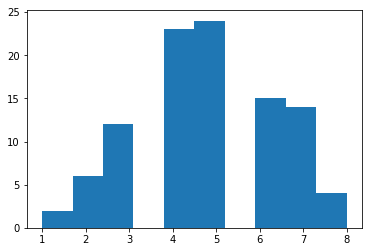

In [106]:
_ = plt.hist(y2_1)

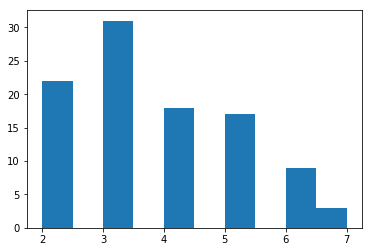

In [107]:
_ = plt.hist(y2_2)

# Random process

Stochastic or random process is a collection of random variables defined on the same outcome space $\Omega$ that take values in the same measureable space $E$ and are indexed by some set $T$. A stochastic process can be written as $\{Y(t,\omega ):t\in T, \omega \in \Omega\}$. 

$T$ is an index set of the random process, it can represent time, 2-dimensional or n-dimensional Euclidean space.

A sample function is a single outcome of a stochastic process, so it is formed by taking a single possible value of each random variable of the stochastic process. If $\{Y(t,\omega ):t\in T\}$ is a stochastic process, then for any point $\omega \in \Omega$, the mapping $Y(\cdot ,\omega ):T\rightarrow S$,
is called a sample function, a realization, or, particularly when $T$ is interpreted as time, a sample path of the stochastic process $\{Y(t,\omega ):t\in T\}$.

## Gaussian process

A time continuous stochastic process $\{Y_{t};t\in T\}$ is Gaussian if and only if for every finite set of indices $t_{1},\ldots ,t_{k} $ in the index set $T$:

$\mathbf {Y} _{t_{1},\ldots ,t_{k}}=(Y_{t_{1}},\ldots ,Y_{t_{k}})$
is a multivariate Gaussian random variable. That is the same as saying every linear combination of $(Y_{t_{1}},\ldots ,Y_{t_{k}})$ has a univariate normal (or Gaussian) distribution.

Multivariate normal distribution $ \mathbf {X} \ \sim \ {\mathcal {N}}({\boldsymbol {\mu }},\,{\boldsymbol {\Sigma }})$ is defined by a vector of mean values $\mu$ and a covariance matrix $\Sigma$:

$${\boldsymbol {\mu }}= E [\mathbf {Y} ]=[E [Y_{1}], E [Y_{2}],\ldots ,E [Y_{k}]]^{\rm {T}}$$

$$ \boldsymbol {\Sigma _{i,j}}= E [(\boldsymbol{Y}-\boldsymbol{\mu})(\boldsymbol{Y}-\boldsymbol{\mu})]= [{Cov} [Y_{i},Y_{j}], i, j \in T]$$

### 1-dimensional

Define process

In [230]:
#Index set
d = 30 #Number of datapoints
T = np.linspace(0, 3, d)[:, None]

# Covariance kernel parameters
ℓ = 0.3 #lengthscale
η = 5 #strength

#Covariance
k = η**2 * pm.gp.cov.ExpQuad(1, ℓ) #kernel
Σ = k(T)

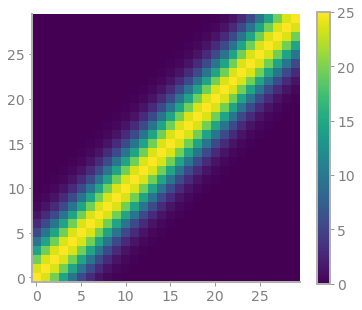

In [184]:
#Show covariance matrix
plt.figure(figsize=(6,5))
m = plt.imshow(Σ.eval(), 
               interpolation='none', 
               origin = (0,0))
plt.colorbar(m)

In [169]:
# A mean function
μ = pm.gp.mean.Zero()

# Define GP
GP = lambda x: np.random.multivariate_normal(mean=μ(T).eval(), 
                                            cov=Σ.eval()
                                             )

Draw samples

In [170]:
n = 50 #Number of samples
samples = np.array(list(map(GP, np.arange(n)))
                  )

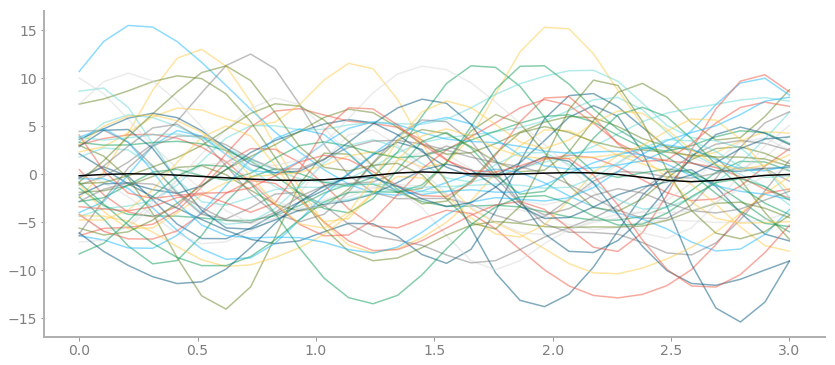

In [171]:
#Plot
fig, ax = plt.subplots(figsize=(14, 6));
_ = ax.plot(T, samples.T, alpha = 0.5)
_ = ax.plot(T, np.mean(samples.T, 1), color = 'black')

In [172]:
columns = list(map(lambda x: ''.join(['t=', str(x)]),
                   np.round(T.T[0], 1)
                    )
              )
samples = pd.DataFrame(samples, columns=columns
            )

Covariance between RVs

/home/ubuntu/anaconda3/envs/pymc_sql_env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


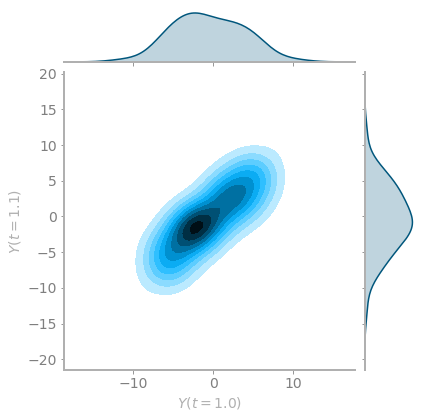

In [420]:
g = sns.jointplot(x="t=1.0", y="t=1.1", data=samples, kind="kde")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$Y(t = 1.0)$", "$Y(t = 1.1)$");

### 2-dimensional

In [232]:
#Two-dimensional index set
xx,yy = np.meshgrid(T,T)
T2 = np.stack((xx.reshape(-1),yy.reshape(-1)), axis=-1)

# Covariance kernel parameters
ℓ = 1 #lengthscale
η = 5 #strength

#Covariance
k = η**2 * pm.gp.cov.Exponential(input_dim=2, ls=ℓ) #kernel
Σ = k(T2)

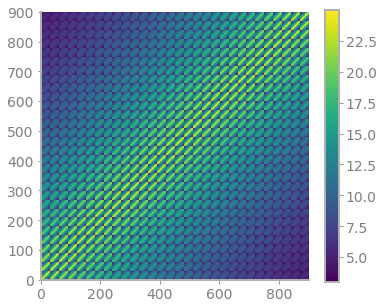

In [233]:
#Show covariance matrix
plt.figure(figsize=(6,5))
m = plt.imshow(Σ.eval(), 
               interpolation='none', 
               origin = (0,0))
plt.colorbar(m)

In [234]:
# A mean function
μ = pm.gp.mean.Zero()

# Observed data
GP2 = lambda x: np.random.multivariate_normal(mean=μ(T2).eval(), 
                                            cov=Σ.eval()
                                             )

In [235]:
#Sample
sample = GP2(0)

sample = pd.DataFrame(sample, columns=['Y'])

sample['x1'] = T2[:, 0]
sample['x2'] = T2[:, 1]

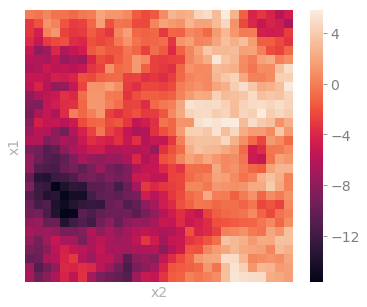

In [236]:
#Plot resulting random field
plt.figure(figsize=(6,5))
sns.heatmap(sample.pivot(index = 'x1', columns = 'x2', values='Y'),
            xticklabels=[],
            yticklabels=[])

# Gaussian process as an inference method

Define GP

In [399]:
#Index set
d = 50 #Number of datapoints
T = np.linspace(0, 3, d)[:, None]

# Covariance kernel parameters
ℓ = 0.3 #lengthscale
η = 5 #strength

#Covariance
k = η**2 * pm.gp.cov.ExpQuad(1, ℓ)
Σ = k(T)

# A mean function
μ = pm.gp.mean.Zero()

# Define GP
GP = lambda x: np.random.multivariate_normal(mean=μ(T).eval(), 
                                            cov=Σ.eval()
                                             )

Generate data

In [346]:
f_true = GP(0) #generate sample
#Noise parameters
σ = 1 #noise amplitdue
ν = 10 #number of degrees of freedom of T-distribution
d_train = 10 #number of training points
ind = np.random.choice(np.arange(d), size = d_train, replace=False) #random indices
T_train = T[ind] #arguments of the training set
f_train = f_true[ind] + σ*np.random.standard_t(ν, size=d_train) #noisy training set with t-distributed noise

Train GP

In [426]:
#Kernel
kernel = 1**2*sklearn.gaussian_process.kernels.RBF(length_scale=0.1, 
                                                    length_scale_bounds=(0, 3)
                                                  ) + 0*sklearn.gaussian_process.kernels.WhiteKernel(1)

#Gaussian process regressor
gpr = sklearn.gaussian_process.GaussianProcessRegressor(kernel = kernel)

Prior

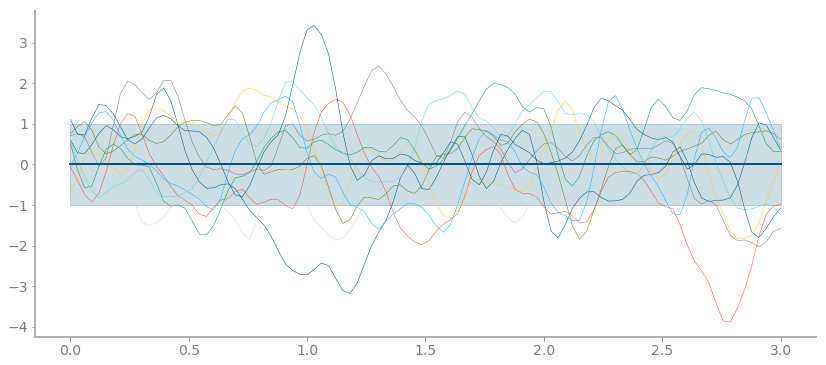

In [442]:
# Plot prior
fig, ax = plt.subplots(figsize=(14, 6));
T_ = np.linspace(0, 3, 100)[:, None]
f_mean, sigma_prior = gpr.predict(T_, return_std=True)
ax.plot(T_, f_mean, color=palette[0], lw=2, zorder=9)
ax.fill_between(T_.squeeze(), f_mean - sigma_prior, f_mean + sigma_prior,
                 alpha=0.2, color=palette[0])
f_samples = gpr.sample_y(T_, 10)
_ = ax.plot(T_.squeeze(), f_samples, lw=0.5)

In [444]:
#Fit and predict
fit = gpr.fit(T_train, f_train  )
f_pred, sigma = gpr.predict(T_, return_std=True)
f_samples = gpr.sample_y(T_, 10)


Plot results

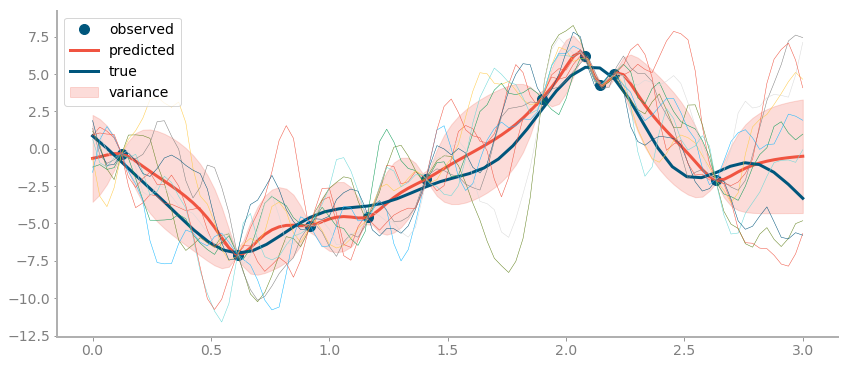

In [445]:
fig, ax = plt.subplots(figsize=(14, 6));
ax.plot(T_train, f_train, 'o', markersize = 10, label = 'observed')
ax.plot(T_, f_pred, label = 'predicted', lw = 3, color = palette[1])
ax.plot(T, f_true, linestyle = '-', color = palette[0], lw = 3, label = 'true')
ax.fill_between(T_.squeeze(), y1 = f_pred + sigma, y2 = f_pred - sigma, alpha = 0.2, color = palette[1], label = 'variance')
_ = ax.plot(T_.squeeze(), f_samples, lw=0.5)
_ = ax.legend()


In [414]:
#Prior
gpr.kernel

1**2 * RBF(length_scale=0.1) + 0**2 * WhiteKernel(noise_level=1)

In [415]:
#Posterior
gpr.kernel_

4.5**2 * RBF(length_scale=0.094) + 0.00316**2 * WhiteKernel(noise_level=1)

# References

* Wikipedia articles - [Random variable](https://en.wikipedia.org/wiki/Random_variable), [Random process](https://en.wikipedia.org/wiki/Stochastic_process), [Gaussian process](https://en.wikipedia.org/wiki/Gaussian_process)
* Discussions about RVs on stackexchange - [What is meant by a random variable](https://stats.stackexchange.com/questions/50/what-is-meant-by-a-random-variable), [diffference between sample and outcome](https://stats.stackexchange.com/questions/107912/what-is-the-difference-between-sample-and-outcome-plus-events-and-observations)
* Hand-wavy explanation of GP - [Visual exploration of GP](https://distill.pub/2019/visual-exploration-gaussian-processes/)
* The book on GPs in ML - [Gaussian processes for machine learning](http://www.gaussianprocess.org/gpml/chapters/)
* Coursera lectures on GP - [bayesian-methods-in-machine-learning](https://www.coursera.org/learn/bayesian-methods-in-machine-learning/home/week/6)
